In [274]:
import sys
sys.path.append('../')
from pathlib import Path
import scipy.signal
import scipy
import pickle
import os
import numpy as np
import h5py
import math
import torch
from torch.utils.data import Dataset, DataLoader
from utils import StandardScaler
from constants import INCLUDED_CHANNELS, FREQUENCY
from data.data_utils import *
import data.data_utils
import utils
import pyedflib

from matplotlib import pyplot as plt
import pywt
from scipy.signal import resample, correlate
from scipy.signal import butter, lfilter, filtfilt
from mpl_toolkits.axes_grid1 import make_axes_locatable

repo_paths = str(Path.cwd()).split('eeg-gnn-ssl')
repo_paths = Path(repo_paths[0]).joinpath('eeg-gnn-ssl')
sys.path.append(repo_paths)
FILEMARKER_DIR = Path(repo_paths).joinpath('data/file_markers_classification')

In [275]:
h5_fn = '../tusz_resampled/00001543_s001_t000.h5'
edf_fn = '../tusz_raw/edf/train/02_tcp_le/015/00001543/s001_2004_07_14/00001543_s001_t000.edf'
seizure_idx = 4 
time_step_size = 1 
clip_len = 12

In [276]:
def computeSliceMatrix(
        h5_fn,
        edf_fn,
        seizure_idx,
        time_step_size=1,
        clip_len=60):
    
    offset = 2 # hard-coded offset

    with h5py.File(h5_fn, 'r') as f:
        signal_array = f["resampled_signal"][()] # (num_channels, num_data_points)
        resampled_freq = f["resample_freq"][()]
    assert resampled_freq == FREQUENCY
    
    # get seizure times
    seizure_times = getSeizureTimes(edf_fn.split('.edf')[0])
    curr_seizure_time = seizure_times[seizure_idx]


    if seizure_idx > 0:
        pre_seizure_end = int(FREQUENCY * seizure_times[seizure_idx - 1][1])
    else:
        pre_seizure_end = 0


    # start_time: start of current seizure - offset / end of previous seizure, whichever comes later
    start_t = max(pre_seizure_end + 1, int(FREQUENCY*(curr_seizure_time[0] - offset)))
    # end_time: (start_time + clip_len) / end of current seizure, whichever comes first    
    end_t = min(start_t + int(FREQUENCY*clip_len), int(FREQUENCY*curr_seizure_time[1]))

    # print(start_t/200, end_t/200)
    
    # get corresponding eeg clip
    signal_array = signal_array[:, start_t:end_t]

    return signal_array[0], signal_array
    
signal, signals = computeSliceMatrix(
h5_fn = h5_fn,
edf_fn = edf_fn,
seizure_idx = seizure_idx,
time_step_size = time_step_size,
clip_len = clip_len
)

In [277]:
def butter_bandpass(lowcut, highcut, order=5):
    return butter(order, [lowcut, highcut], fs = 200, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, order=5):
    b, a = butter_bandpass(lowcut, highcut, order=order)
    y = filtfilt(b, a, data)
    return y

In [278]:
def compute_dwt(signals, n):
    d = []
    for i in range(signals.shape[0]):
        coeffs = pywt.wavedec(signals[i], 'db6', mode='sym', level=4)
        coeffs = np.hstack(coeffs)
        d.append(coeffs)       
        
    d = np.vstack(d)
    return d

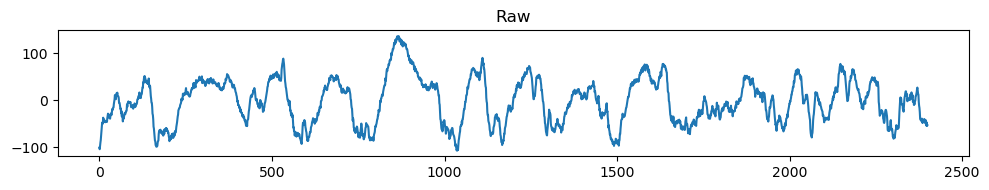

In [279]:
plt.figure(figsize = (10,2), tight_layout=True)
plt.plot(signal)
plt.title('Raw')
plt.savefig('./raw.png', dpi=200)
plt.show()

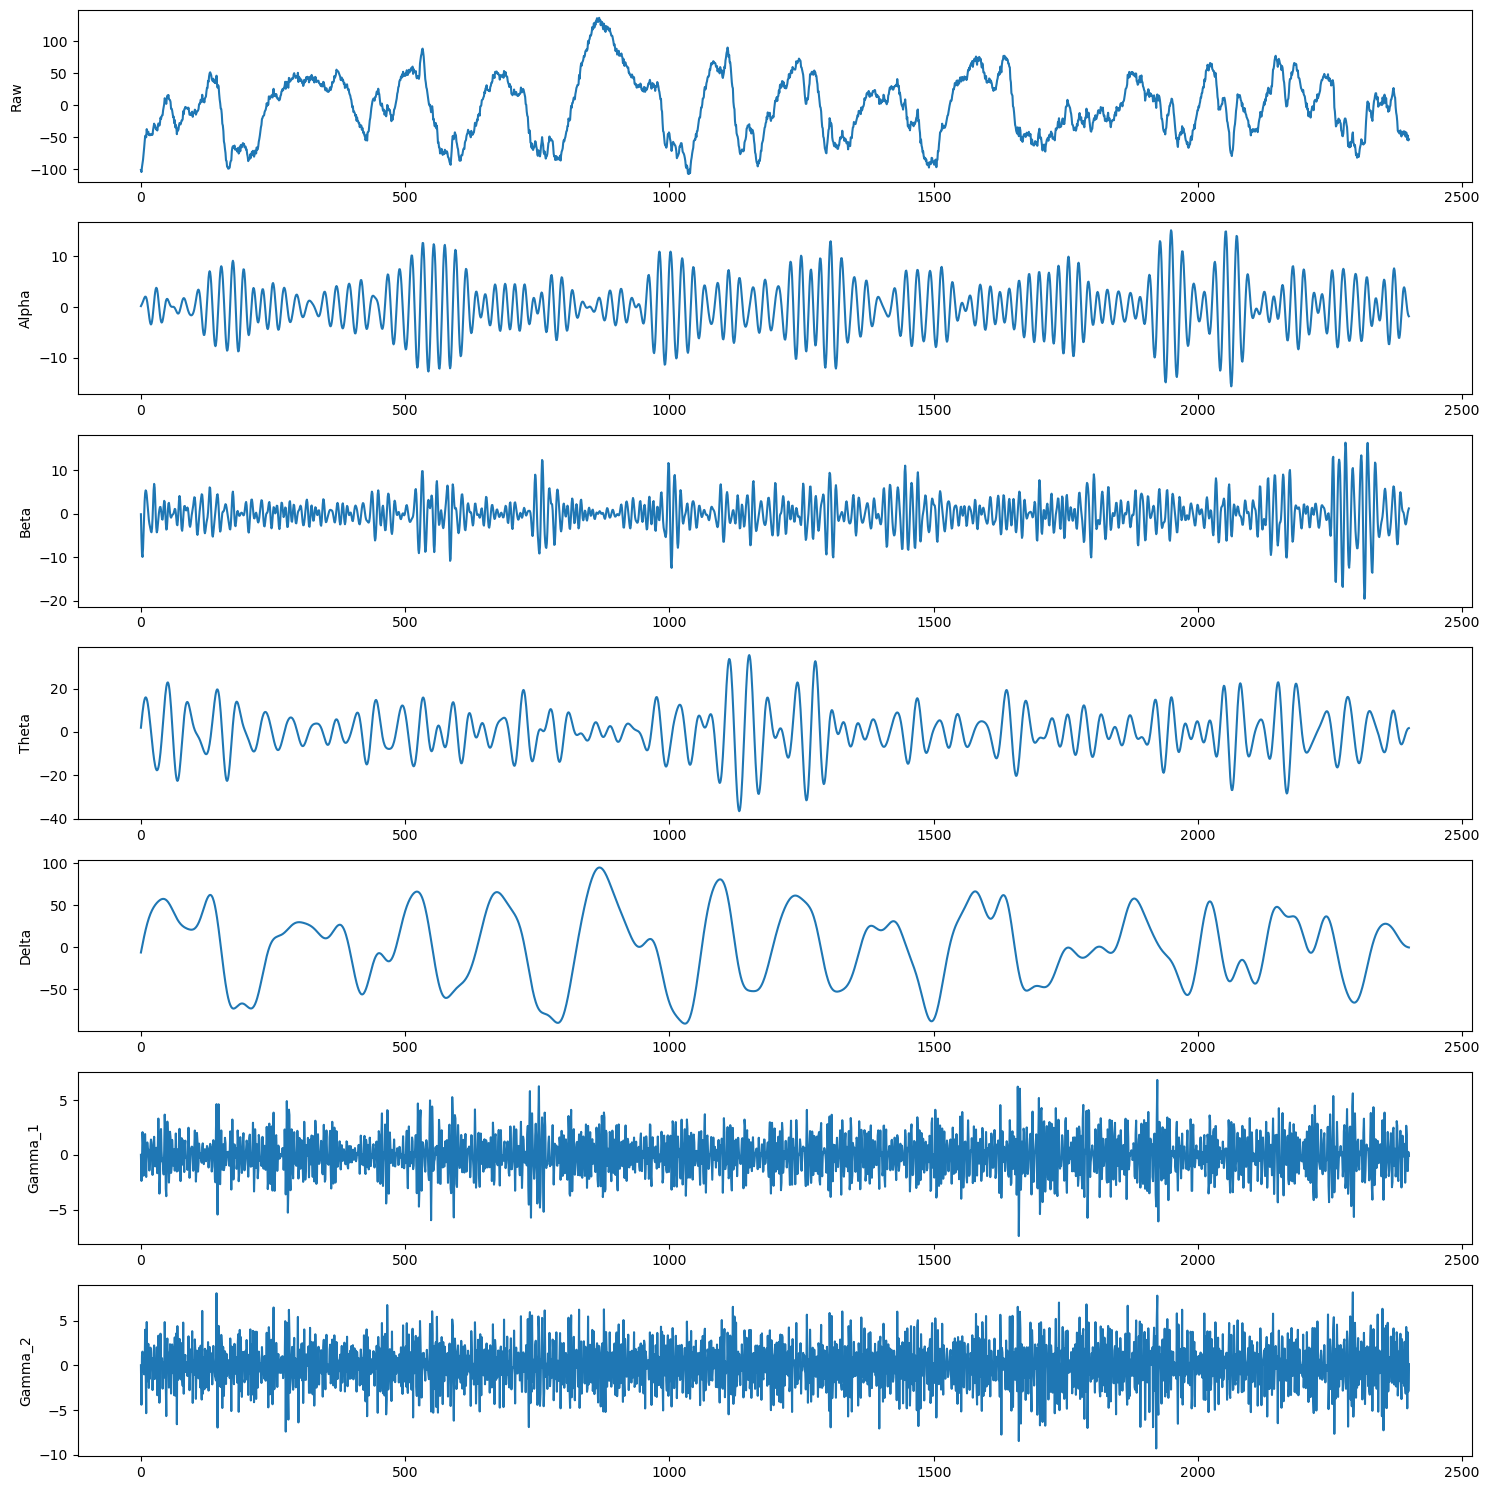

In [280]:
fig, axs = plt.subplots(7, 1, figsize=(15, 15), tight_layout=True)


axs[0].plot(signal)
axs[0].set_ylabel('Raw')

axs[1].plot(butter_bandpass_filter(signal, 8, 12, order=4))
axs[1].set_ylabel('Alpha')

axs[2].plot(butter_bandpass_filter(signal, 12, 30, order=4))
axs[2].set_ylabel('Beta')

axs[3].plot(butter_bandpass_filter(signal, 4, 8, order=4))
axs[3].set_ylabel('Theta')

axs[4].plot(butter_bandpass_filter(signal, 0.5, 4, order=4))
axs[4].set_ylabel('Delta')

axs[5].plot(butter_bandpass_filter(signal, 30, 60, order=4))
axs[5].set_ylabel('Gamma_1')

axs[6].plot(butter_bandpass_filter(signal, 30, 95, order=4))
axs[6].set_ylabel('Gamma_2')

plt.savefig('./bandpass.png', dpi=200)
plt.show()

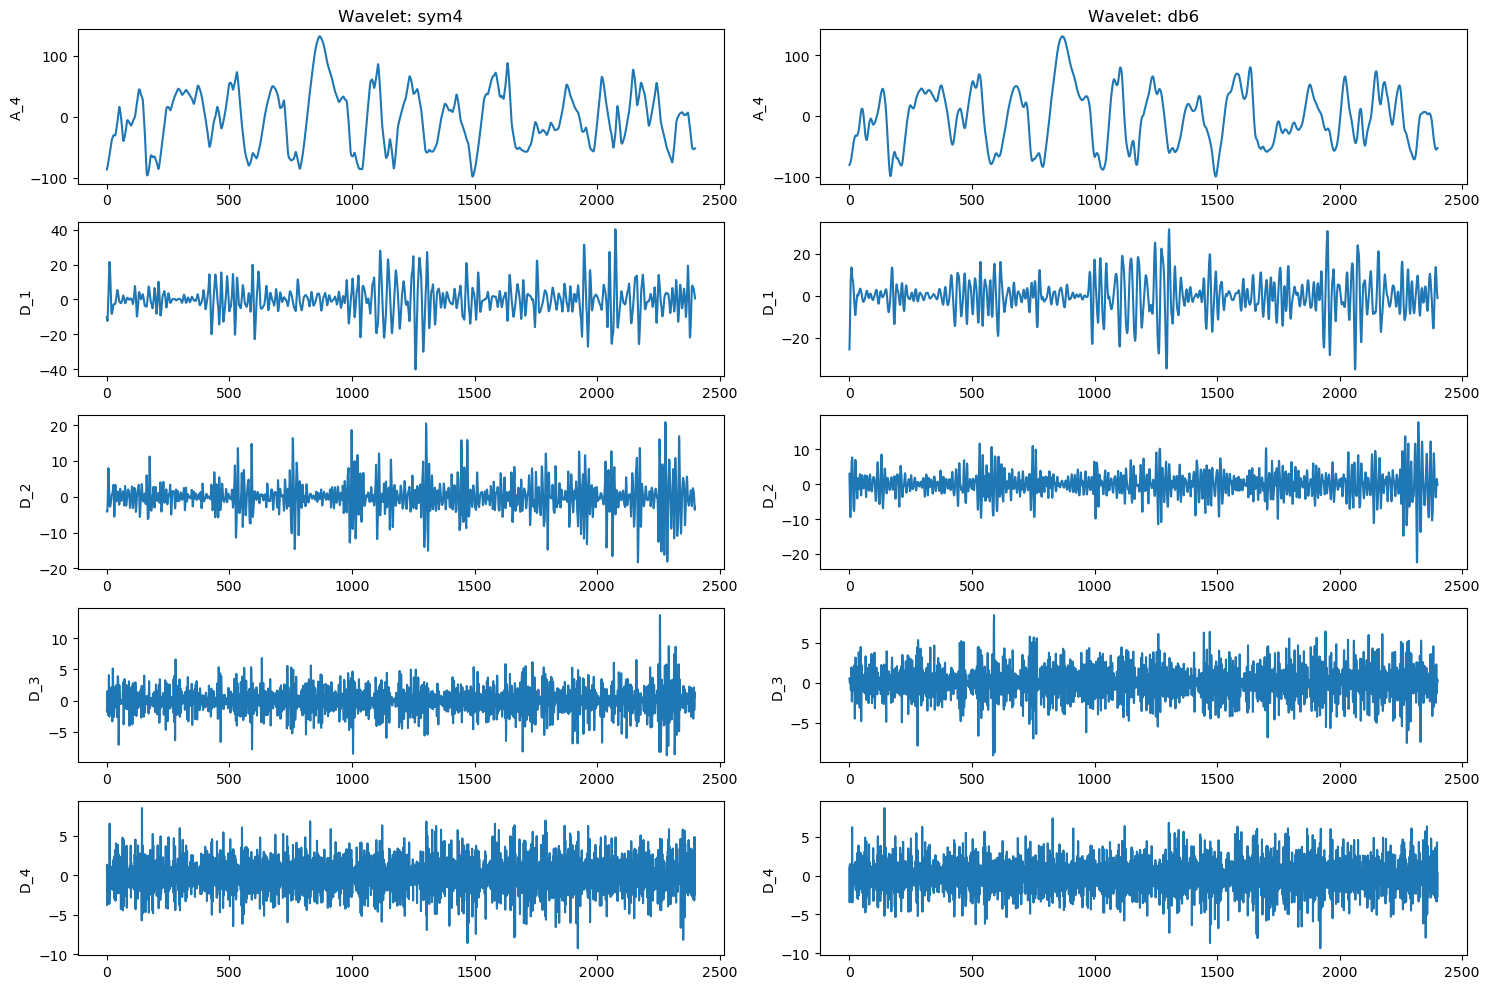

In [281]:
fig, axs = plt.subplots(5, 2, figsize=(15, 10), tight_layout=True)

coeffs = pywt.wavedec(signal, 'sym4', mode='sym', level=4)
for j in range(len(coeffs)):
    axs[j,0].plot(pywt.waverec( [ np.zeros(len(coeffs[c])) if c!=j else coeffs[c]  for c in range(len(coeffs)) ] ,'sym4', mode='sym'))
    if j == 0:
        axs[j,0].set_title('Wavelet: sym4')
    axs[j,0].set_ylabel(f'D_{j}' if j>=1 else 'A_4')
    
coeffs = pywt.wavedec(signal, 'db6', mode='sym', level=4)
for j in range(len(coeffs)):
    axs[j,1].plot(pywt.waverec( [ np.zeros(len(coeffs[c])) if c!=j else coeffs[c]  for c in range(len(coeffs)) ] ,'db6', mode='sym'))
    if j == 0:
        axs[j,1].set_title('Wavelet: db6')
    axs[j,1].set_ylabel(f'D_{j}' if j>=1 else 'A_4')

plt.savefig('./dwt.png', dpi=200)
plt.show()

(100,)


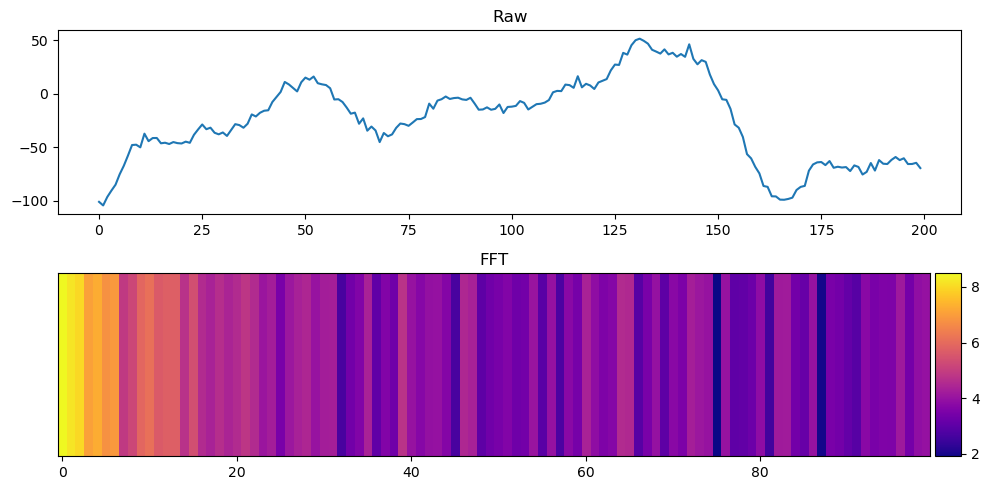

In [282]:
# fourier transform
n=200

fourier_signal = fft(signals[:,:n], n=n, axis=-1)  # FFT on the last dimension

# only take the positive freq part
idx_pos = int(np.floor(n / 2))
fourier_signal = fourier_signal[:, :idx_pos]
amp = np.abs(fourier_signal)
amp[amp == 0.0] = 1e-8  # avoid log of 0

FT = np.log(amp)[0]
print(FT.shape)

fig, axs = plt.subplots(2, 1, figsize=(10, 5), tight_layout=True)
axs[0].plot(signal[:200])
axs[0].set_title('Raw')

im = axs[1].imshow(FT[np.newaxis,:], cmap="plasma", aspect="auto")
divider = make_axes_locatable(axs[1])
fig.colorbar(im, cax = divider.append_axes('right', size='3%', pad=0.05))
axs[1].set_title('FFT')
axs[1].set_yticks([])

plt.savefig('./fft.png', dpi=200)
plt.show()

(100,)


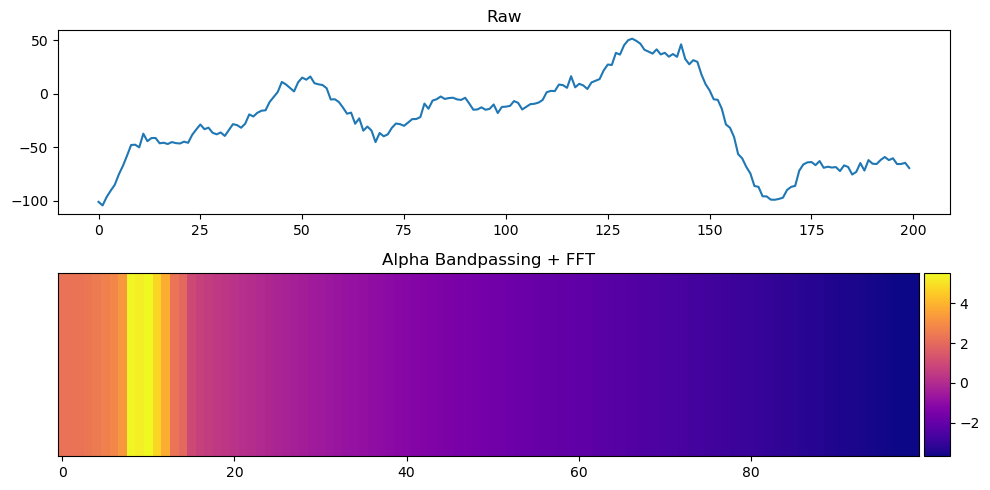

In [283]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# fourier transform
n=200
signals_ = butter_bandpass_filter(signals[:,:n], 8, 12, order=4)
fourier_signal = fft(signals_, n=n, axis=-1)  # FFT on the last dimension

# only take the positive freq part
idx_pos = int(np.floor(n / 2))
fourier_signal = fourier_signal[:, :idx_pos]
amp = np.abs(fourier_signal)
amp[amp == 0.0] = 1e-8  # avoid log of 0

FT = np.log(amp)[0]
print(FT.shape)

fig, axs = plt.subplots(2, 1, figsize=(10, 5), tight_layout=True)
axs[0].plot(signal[:200])
axs[0].set_title('Raw')

im = axs[1].imshow(FT[np.newaxis,:], cmap="plasma", aspect="auto")
divider = make_axes_locatable(axs[1])
fig.colorbar(im, cax = divider.append_axes('right', size='3%', pad=0.05))
axs[1].set_title('Alpha Bandpassing + FFT')
axs[1].set_yticks([])

plt.savefig('./alpha_fft.png', dpi=200)
plt.show()